In [1]:
import logging
import os
import time
import warnings
from functools import partial  # for pd.Series.map(ztfs)
from multiprocessing.pool import Pool
from pathlib import Path

import cartopy.crs as ccrs
import geopandas
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from matplotlib.colors import BoundaryNorm
from tqdm import tqdm

import G211
import lightning
from ml_functions import brier_skill_score, get_args, get_flash_pred
from spc import get_issuance_time
from statisticplot import ax_features, stat_plots

sns.set_theme()

logging.basicConfig(level=logging.WARNING, format="%(asctime)s %(message)s", force=True)
tmpdir = Path(os.getenv("TMPDIR"))

2024-07-18 17:36:46.106360: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-18 17:36:46.137751: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#%load_ext autoreload
#%autoreload 2

In [3]:
# map projection
map_crs = G211.g211
grid = G211.grid
grid = grid.to_crs(ccrs.PlateCarree())
dpi = 200
conus_mask = G211.mask

### Load SPC Tstm Outlook
downloaded by [get_enhtstm.ipynb](get_enhtstm.ipynb)


In [4]:
sfiles = (tmpdir / "enhtstm").glob("????/*.zip")
sfiles = sorted(sfiles)
column = "DN"
sfiles[0].name, sfiles[-1].name, len(sfiles)

('enh00_20200101_012000_202001010525-shp.zip',
 'enh20_20231231_311600_202312311222-shp.zip',
 17593)

In [5]:
obsvar = "cg"
o_thresh = 1
twin = 4
rptdist = 20
clobber = False

platform = "glm" if obsvar == "flashes" else "wbug"

f = f"{obsvar}_{rptdist}km_{twin}hr"
# Define observation/probability thresholds
thresh = pd.Series([o_thresh], name=f"{obsvar} threshold")
pthreshSPC = pd.Series([0, 10, 40, 70], name="fcst prob\nthresh") / 100.0
args = get_args(o_thresh, twin)
args.teststart = pd.to_datetime("20220101")
args.testend = pd.to_datetime("20230101")
args

Namespace(batchnorm=True, batchsize=1024, clobber=False, debug=False, dropout=0.0, epochs=30, labels=['cg_20km_4hr', 'ic_20km_4hr', 'cg.ic_20km_4hr', 'flashes_20km_4hr', 'cg_40km_4hr', 'ic_40km_4hr', 'cg.ic_40km_4hr', 'flashes_40km_4hr'], fhr=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], fits=None, flash=1, folds=None, kfold=1, idate=None, ifile=None, learning_rate=0.001, model='HRRR', neurons=[1024], nfits=10, nprocs=0, optimizer='Adam', reg_penalty=0.0, savedmodel='/glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr', seed=-1, trainstart=Timestamp('2019-10-02 00:00:00'), trainend=Timestamp('2020-12-02 00:00:00'), teststart=Timestamp('2022-01-01 00:00:00'), testend=Timestamp('2023-01-01 00:00:00'), twin=4, suite='default')

In [6]:
def spc_forecast_obs(sfile: str) -> pd.DataFrame:
    """
    Parameters
    ----------
    sfile:str
        a path like
        '/glade/derecho/scratch/ahijevyc/tmp/enhtstm/2020/enh00_20200105_052000_202001051206-shp.zip'
        from which you can derive issuance and valid time range

    Returns
    -------
        pd.DataFrame with forecast and observations from same period
    """

    assert twin > 1, (
        "no NNPF time windows for twin == 1 that conform to SPC time windows. "
        "NNPF twin=1 start and end on the half-hour, while SPC time windows "
        "start and end on the hour. But that is okay. You can still plot "
        "NNPF performance at all valid times, regardless of SPC fcst below."
    )
    record = os.path.basename(sfile)

    # If there are multiple datasets in a folder in the ZIP file, you also have to specify the filename:
    filename = record.rstrip('-shp.zip') + '.shp'
    ifile = f"{sfile}!{filename}"

    f = geopandas.read_file(ifile).to_crs(ccrs.PlateCarree())

    # Get forecast valid start and end from sfile string.
    issue, valid_start, valid_end = get_issuance_time(record)
    logging.info(f"{issue} {valid_start} {valid_end}")

    # Get observations from DataFrame from ml_functions.load_df()
    # instead of lightning.get_obs()
    # so you have the same data, and don't "repeat" the same
    # function with different code.
    # get_obs allows GLM or ENTLN to be missing for a time
    # but load_df does not.

    # Uses `obs` DataFrame already sliced from Y DataFrame outside function.
    # I don't include it as an input parameter because this is run in a Pool.
    # I think it would make a copy of obs for each worker
    # if I included it as an input parameter.

    valid_times = pd.date_range(
        start=valid_start + pd.Timedelta(hours=twin / 2),
        end=valid_end - pd.Timedelta(hours=twin / 2),
        freq=f"{twin}h",
    )
    # if all expected valid_times are available
    logging.info(f"{len(valid_times)} valid_times {valid_times}")
    if all(
        [valid_time in obs.index.get_level_values("valid_time") for valid_time in valid_times]
    ):
        with warnings.catch_warnings():
            warnings.simplefilter(action="ignore", category=FutureWarning)
            # Reduce initialization_time dimension for multiple
            # initialization_times that have the same valid_time.
            # The validation data, obs, are the same for each init time so just
            # take the first.
            # You don't what what position "valid_time" level is in. It could be
            # 2nd position, or 4th, or whatever.
            ix = obs.index.get_level_values("valid_time").isin(valid_times)
            o = (obs.loc[ix, args.labels]
                #obs.loc[
                #    (slice(None), slice(None), slice(None), valid_times),
                #    args.labels,
                #]
                .groupby(["x", "y", "valid_time"])
                .first()
            )
        o = o.groupby(
            ["x", "y"]
        ).sum()  # sum flashes for each (x,y) along valid_times dimension
    else:
        return None

    # Assign value to conus grid points within polygons
    f = grid[conus_mask.values.ravel()].sjoin(f, how="left")

    f["record"] = record
    f["issue"] = issue
    # convert to str avoids TypeError: Object of type Timestamp is not JSON serializable
    # when saving to parquet
    f["valid_start"] = valid_start.strftime("%Y%m%d %H:%M")
    f["valid_end"] = valid_end.strftime("%Y%m%d %H:%M")
    columns = ["record", "DN", "issue", "valid_start", "valid_end"]
    # fill missing fcst prob (outside any polygon) with 0. Join with obs.
    f = f[columns].fillna(0).join(o)
    f = f.set_index("record", append=True)

    return f

### Load DataFrame of NNPF forecasts / observations

In [7]:
# get observations from NNPF forecast/obs DataFrame
Y = get_flash_pred(args, clobber=clobber)

# ensmean of fits and folds
# Don't be clever by subtracting {"fit", "fold"} set from Y.index.names
# Order of returned list of levels was random. valid_time did not always come 2nd.
levels = ["initialization_time", "valid_time", "y", "x", "forecast_hour", "lat", "lon"]
logging.warning(f"groupby {levels} for ensmean")
ensmean = Y.groupby(level=levels).mean()

# obs used in spc_forecast_obs() defined above
logging.warning("obs (label) slice")
obs = ensmean.xs("y_label", axis="columns", level=0)

2024-07-18 17:36:50,281 read saved model output /glade/derecho/scratch/ahijevyc/tmp/Y.001+4hr.2022-01-01 00:00:00-2023-01-01 00:00:00.par
2024-07-18 17:37:42,534 done
2024-07-18 17:37:42,535 groupby ['initialization_time', 'valid_time', 'y', 'x', 'forecast_hour', 'lat', 'lon'] for ensmean
2024-07-18 17:38:50,839 obs (label) slice


## Verify SPC Thunderstorm Outlook

### Match obs to each SPC forecast in parallel

In [8]:
ffile = (
    tmpdir
    / f"spc_fcst.{args.teststart.strftime('%Y%m%d%H')}-{args.testend.strftime('%Y%m%d%H')}.{twin}hr.par"
)

if not clobber and os.path.exists(ffile):  # and os.path.exists(ofile):
    logging.warning(f"read {ffile} {os.path.getsize(ffile)/1e6:.1f}M ")
    spc_fcst = pd.read_parquet(ffile)
else:
    logging.warning(f"make new file {ffile}")
    if twin == 2:
        logging.warning("Sure u want to compare NNPFs with 2-hour time window to SPC?")

    assert obs[f].sum() > 0, (
        "no lightning obs. did you run cells further down that changed"
        " obs and then come back"
        " to this cell?"
    )

    # Use multiple cpus (like 16) and 60+GB memory.
    # 16 cpu, 89 GB, 16 processes took 17 minutes (twin=4)
    with Pool(processes=16) as pool:
        result = pool.map(
            spc_forecast_obs,
            tqdm(sfiles),
        )

    spc_fcst = pd.concat([x for x in result if x is not None])
    spc_fcst.to_parquet(ffile)

# tried saving this to parquet ofile but tuple in column broke arrow engine
spc_fcst["prodid"] = list(
    zip(
        spc_fcst.issue,
        pd.to_datetime(spc_fcst.valid_start).dt.hour,
        pd.to_datetime(spc_fcst.valid_end).dt.hour,
    )
)

logging.info("trim spc_fcst to testing range of neural network")
print(spc_fcst.valid_start.min())
print(spc_fcst.valid_start.max())
before_trim = len(spc_fcst)
spc_fcst = spc_fcst[
    (pd.to_datetime(spc_fcst.valid_start) >= pd.to_datetime(args.teststart))
    & (pd.to_datetime(spc_fcst.valid_end) <= pd.to_datetime(args.testend))
]
logging.warning(
    f"kept {len(spc_fcst)}/{before_trim} ({len(spc_fcst)/before_trim:%}) spc fcsts"
)

if args.teststart < pd.to_datetime("20220101"):
    assert "enh00_20211231_312000_202112310559-shp.zip" in spc_fcst.index.get_level_values(
        "record"
    )

2024-07-18 17:38:51,187 read /glade/derecho/scratch/ahijevyc/tmp/spc_fcst.2022010100-2023010100.4hr.par 4.4M 


20220101 00:00
20221231 20:00


2024-07-18 17:38:57,660 kept 5579928/5579928 (100.000000%) spc fcsts


In [9]:
spc_fcst.valid_start

y   x   record                                    
12  48  enh04_20211231_010000_202112311237-shp.zip    20220101 00:00
    49  enh04_20211231_010000_202112311237-shp.zip    20220101 00:00
    69  enh04_20211231_010000_202112311237-shp.zip    20220101 00:00
    70  enh04_20211231_010000_202112311237-shp.zip    20220101 00:00
13  47  enh04_20211231_010000_202112311237-shp.zip    20220101 00:00
                                                           ...      
46  25  enh20_20221231_311600_202212311251-shp.zip    20221231 16:00
    26  enh20_20221231_311600_202212311251-shp.zip    20221231 16:00
    27  enh20_20221231_311600_202212311251-shp.zip    20221231 16:00
    28  enh20_20221231_311600_202212311251-shp.zip    20221231 16:00
    29  enh20_20221231_311600_202212311251-shp.zip    20221231 16:00
Name: valid_start, Length: 5579928, dtype: object

In [10]:
spc_fcst[(spc_fcst.prodid == ("1700", 20, 0)) & (spc_fcst["valid_start"] == "20221230 20:00")]

DN issue     valid_start  \
y  x  record                                                                  
12 48 enh00_20221230_302000_202212301315-shp.zip  0.0  1700  20221230 20:00   
   49 enh00_20221230_302000_202212301315-shp.zip  0.0  1700  20221230 20:00   
   69 enh00_20221230_302000_202212301315-shp.zip  0.0  1700  20221230 20:00   
   70 enh00_20221230_302000_202212301315-shp.zip  0.0  1700  20221230 20:00   
13 47 enh00_20221230_302000_202212301315-shp.zip  0.0  1700  20221230 20:00   
...                                               ...   ...             ...   
46 25 enh00_20221230_302000_202212301602-shp.zip  0.0  1700  20221230 20:00   
   26 enh00_20221230_302000_202212301602-shp.zip  0.0  1700  20221230 20:00   
   27 enh00_20221230_302000_202212301602-shp.zip  0.0  1700  20221230 20:00   
   28 enh00_20221230_302000_202212301602-shp.zip  0.0  1700  20221230 20:00   
   29 enh00_20221230_302000_202212301602-shp.zip  0.0  1700  20221230 20:00   

                                                       valid_end  cg_20km_4hr  \
y  x  record                                                                    
12 48 enh00_20221230_302000_202212301315-shp.zip  20221231 00:00          0.0   
   49 enh00_20221230_302000_202212301315-shp.zip  20221231 00:00          0.0   
   69 enh00_20221230_302000_202212301315-shp.zip  20221231 00:00          0.0   
   70 enh00_20221230_302000_202212301315-shp.zip  20221231 00:00          0.0   
13 47 enh00_20221230_302000_202212301315-shp.zip  20221231 00:00          0.0   
...                                                          ...          ...   
46 25 enh00_20221230_302000_202212301602-shp.zip  20221231 00:00          0.0   
   26 enh00_20221230_302000_202212301602-shp.zip  20221231 00:00          0.0   
   27 enh00_20221230_302000_202212301602-shp.zip  20221231 00:00          0.0   
   28 enh00_20221230_302000_202212301602-shp.zip  20221231 00:00          0.0   
   29 enh00_20221230_302000_202212301602-shp.zip  20221231 00:00          0.0   

                                                  ic_20km_4hr  cg.ic_20km_4hr  \
y  x  record                                                                    
12 48 enh00_20221230_302000_202212301315-shp.zip          0.0             0.0   
   49 enh00_20221230_302000_202212301315-shp.zip          0.0             0.0   
   69 enh00_20221230_302000_202212301315-shp.zip          0.0             0.0   
   70 enh00_20221230_302000_202212301315-shp.zip          0.0             0.0   
13 47 enh00_20221230_302000_202212301315-shp.zip          0.0             0.0   
...                                                       ...             ...   
46 25 enh00_20221230_302000_202212301602-shp.zip          0.0             0.0   
   26 enh00_20221230_302000_202212301602-shp.zip          0.0             0.0   
   27 enh00_20221230_302000_202212301602-shp.zip          0.0             0.0   
   28 enh00_20221230_302000_202212301602-shp.zip          0.0             0.0   
   29 enh00_20221230_302000_202212301602-shp.zip          0.0             0.0   

                                                  flashes_20km_4hr  \
y  x  record                                                         
12 48 enh00_20221230_302000_202212301315-shp.zip               0.0   
   49 enh00_20221230_302000_202212301315-shp.zip               0.0   
   69 enh00_20221230_302000_202212301315-shp.zip               0.0   
   70 enh00_20221230_302000_202212301315-shp.zip               0.0   
13 47 enh00_20221230_302000_202212301315-shp.zip               0.0   
...                                                            ...   
46 25 enh00_20221230_302000_202212301602-shp.zip               0.0   
   26 enh00_20221230_302000_202212301602-shp.zip               0.0   
   27 enh00_20221230_302000_202212301602-shp.zip               0.0   
   28 enh00_20221230_302000_202212301602-shp.zip               0.0   
   29 enh00_20221230_302000_202212301602-shp.zip               0.0   

    

In [11]:
spc_fcst.loc[(12,48,slice(None))].reset_index().groupby(["issue", "valid_start"]).size()[spc_fcst.loc[(12,48,slice(None))].reset_index().groupby(["issue", "valid_start"]).size() > 1]

issue  valid_start   
0130   20220205 04:00    2
       20221110 04:00    2
0600   20220420 12:00    2
1300   20220125 16:00    4
       20220125 20:00    4
                        ..
2100   20221010 04:00    2
       20221021 00:00    2
       20221021 04:00    2
       20221215 00:00    2
       20221215 04:00    2
Length: 124, dtype: int64

In [12]:
spc_fcst[(spc_fcst.issue == "0600") & (spc_fcst.valid_start == "20210122 12:00")].index.get_level_values("record").unique()

Index([], dtype='object', name='record')

[('0600', 12, 16)] [357] 0.192
[('0600', 16, 20)] [340] 0.236
[('1300', 16, 20)] [369] 0.238
[('0600', 20, 0)] [342] 0.322
[('1300', 20, 0)] [348] 0.323
[('1700', 20, 0)] [377] 0.338
[('1300', 0, 4)] [338] 0.232
[('1700', 0, 4)] [375] 0.246
[('2100', 0, 4)] [357] 0.250
[('1700', 4, 12)] [351] 0.248
[('2100', 4, 12)] [362] 0.250
[('0130', 4, 12)] [350] 0.266


2024-07-18 17:39:14,273 /glade/derecho/scratch/ahijevyc/tmp/enhtstm.001+cg_20km_4hr_20km.png


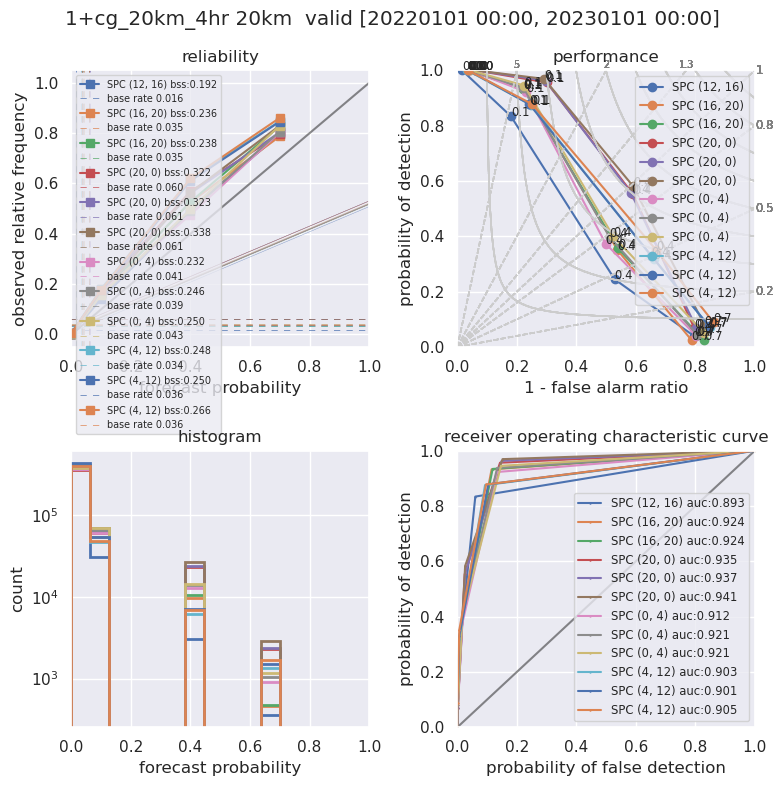

In [13]:
def valid_hour_str(prodids):
    valid_hour_range = prodids[0][1:]  # last 2 elements of first prodids tuple
    same_valid_hour_range = len(set([x[1:] for x in prodids])) == 1
    if same_valid_hour_range:
        return " " + str(valid_hour_range)
    return ""


# Aggregate by valid time
prodidss = [
    [("0600", 12, 16)],
    [("0600", 16, 20), ("1300", 16, 20)],
    [("0600", 20, 0), ("1300", 20, 0), ("1700", 20, 0)],
    [("1300", 0, 4), ("1700", 0, 4), ("2100", 0, 4)],
    [("1700", 4, 12), ("2100", 4, 12), ("0130", 4, 12)],
]

# Flatten list of lists to get every issuance and valid time in its own list
prodidss = [[x] for prodid in prodidss for x in prodid]
# All together
#prodidss = [[x for prodid in prodidss for x in prodid]]

ncols, nrows = 2, 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 4, nrows * 4))
title = ""


spc_bss = {}
for prodids in prodidss:
    logging.info(f"forecast products for {len(prodids)} prodids")
    ihr = spc_fcst.prodid.isin(prodids)
    assert ihr.sum()
    #print(ihr.sum() / G211.mask.values.sum())

    # 1308 CONUS points per forecast
    cnt = (spc_fcst[ihr].groupby("prodid").size() /G211.mask.values.sum()).astype(int)

    print(cnt.index.values, cnt.values, end=" ")

    title += "  ".join([f"{c}{v}" for c, v in list(zip(cnt, cnt.index))])

    thisf = spc_fcst.loc[ihr, "DN"] / 100
    thisf.name = "SPC" + valid_hour_str(prodids)

    fig = stat_plots(
        spc_fcst.loc[ihr, f],
        thisf,
        thresh=thresh,
        pthresh=pthreshSPC,
        o_thresh_roc=o_thresh,
        sep=0.01,
        n_bins=11,
        fig=fig,
    )
    if len(prodids) == 1:
        # Remember this for later
        spc_bss[prodids[0]] = brier_skill_score(spc_fcst.loc[ihr,f]>=o_thresh, thisf)

axes[0,0].set_xlabel("forecast probability") # neat for paper
axes[0,0].set_ylabel("observed relative frequency") # neat for paper

title = f"{o_thresh}+{f} {rptdist}km"
title += f"  valid [{spc_fcst.valid_start.min()}, {spc_fcst.valid_end.max()}]"
plt.suptitle(title, wrap=True)
plt.tight_layout()
ofile = tmpdir / f"enhtstm.{o_thresh:03d}+{f}_{rptdist}km.png"
plt.savefig(ofile, dpi=dpi)
logging.warning(ofile)

2024-07-18 17:39:15,277 /glade/derecho/scratch/ahijevyc/tmp/cnt.png


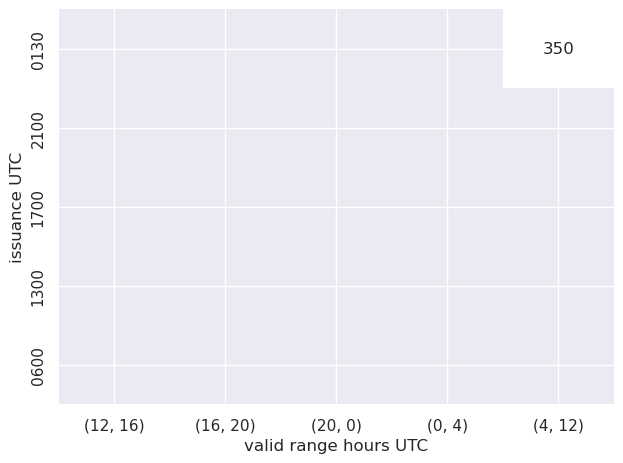

In [14]:
plt.close('all')
def plot_cnt(cnt, **kwargs):
    df = pd.DataFrame(
        cnt.index.tolist(),
        columns=["issuance UTC", "valid_start_hour", "valid_end_hour"],
    )
    df["valid range hours UTC"] = list(zip(df.valid_start_hour, df.valid_end_hour))
    df["n"] = cnt.values
    df = df.reset_index().pivot(
        columns="valid range hours UTC", index="issuance UTC", values="n"
    )
    df = df.reindex(
        ["0130", "2100", "1700", "1300", "0600"],
        columns=[(12, 16), (16, 20), (20, 0), (0, 4), (4, 12)],
    )
    g = sns.heatmap(df, annot=True, fmt="3.0f", cbar=False, **kwargs)
    return g


g = plot_cnt(
    cnt,
    cmap=mpl.colors.LinearSegmentedColormap.from_list(
        "cnt", ["white", fig.get_axes()[0].get_lines()[-1].get_color()]
    ),
)
ofile = tmpdir / "cnt.png"
plt.tight_layout()
plt.savefig(ofile, dpi=dpi)
logging.warning(ofile)

## Verify neural network probability forecast NNPF

In [15]:
ensmean.index.get_level_values("forecast_hour").unique()

Index([48, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
      dtype='int32', name='forecast_hour')

## Get obsvar at rptdist and twin from NNPF obs and fcst
### Plot NNPF performance at all valid times, regardless of SPC fcst

In [16]:
from shapely.geometry import Polygon

def statjob(group: pd.DataFrame) -> pd.DataFrame:
    logging.info(f"statjob: {group.name}")
    # seperate y_pred and labels and drop level 0
    y_pred = group.xs("y_pred", axis="columns", level=0)
    # labels went from bool to object dtype, so fix it or roc_auc_score will not recognize format
    labels = group.xs("y_label", axis="columns", level=0).astype(bool)

    bss = brier_skill_score(labels, y_pred)
    base_rate = labels.mean()
    # Default value is np.nan
    # Don't assign Series to auc and aps on same line or they will remain equal even if you change one
    auc = pd.Series(np.nan, index=labels.columns)
    aps = pd.Series(np.nan, index=labels.columns)
    # auc and aps require 2 unique labels, i.e. both True and False
    two = labels.nunique() == 2
    if two.any():
        # average=None returns a metric for each label instead of one group average of all labels
        auc[two] = sklearn.metrics.roc_auc_score(
            labels.loc[:, two], y_pred.loc[:, two], average=None
        )
        aps[two] = sklearn.metrics.average_precision_score(
            labels.loc[:, two], y_pred.loc[:, two], average=None
        )
    n = y_pred.count()
    # geometry for geopandas dataframe
    forecast_hour, lat_bin, lon_bin = group.name
    poly = Polygon(
        (
            (lon_bin.left, lat_bin.left),
            (lon_bin.left, lat_bin.right),
            (lon_bin.right, lat_bin.right),
            (lon_bin.right, lat_bin.left),
        )
    )

    out = pd.DataFrame(
        dict(
            bss=bss,
            base_rate=base_rate,
            auc=auc,
            aps=aps,
            n=n,
            geometry=poly,
            forecast_hour=0.5 * (forecast_hour.left + forecast_hour.right),
        )
    )
    out.index.name = "class"
    return out

In [17]:
tqdm.pandas()
fhr_bin = pd.cut(ensmean.index.get_level_values("forecast_hour"), bins=range(0, 49, 6))
lat_bin = pd.cut(ensmean.index.get_level_values("lat"), bins=np.arange(25, 52.5, 2.5))
lon_bin = pd.cut(ensmean.index.get_level_values("lon"), bins=np.arange(-126, -64, 3))

by_llfhr = ensmean.groupby(
    by=[fhr_bin, lat_bin, lon_bin],
    observed=True,
).progress_apply(statjob)

by_llfhr.index.names = ("fhr_bin", "lat_bin", "lon_bin", "class")

100%|██████████| 1128/1128 [01:20<00:00, 13.97it/s]


In [18]:
import folium.plugins

m = folium.plugins.DualMap(location=[37, -95], zoom_start=3, layout="horizontal")

s = fhr_bin.categories[3]  # pick a forecast hour bin
print(s)
gdf = geopandas.GeoDataFrame(
    by_llfhr.xs(f, level="class").xs(s, level="fhr_bin"), crs=ccrs.PlateCarree()
)
gdf.explore(
    column="bss",
    vmin=0.0,
    vmax=0.6,
    style_kwds={"fillOpacity": 0.8},
    cmap="Greens",
    m=m.m2,
)
gdf.explore(
    column="base_rate",
    vmin=0,
    vmax=0.02 * twin,
    style_kwds={"fillOpacity": 0.8},
    cmap="Purples",
    m=m.m1,
)

(18, 24]


2024-07-18 17:40:43,841 /glade/derecho/scratch/ahijevyc/tmp/spatial.png


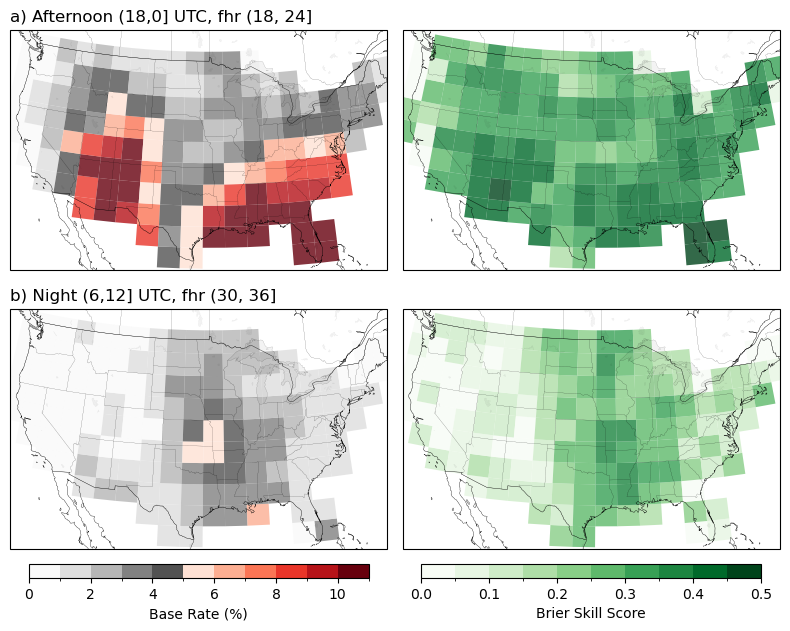

In [19]:
sns.reset_defaults()
%matplotlib inline
extent = (-121, -72, 23, 50)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 6.6), subplot_kw={"projection": map_crs})

legend_kwds = dict(orientation= "horizontal", shrink=0.9, aspect=25, pad=0.05 )

for icat, row in zip([3,5], axes):
    s = fhr_bin.categories[icat]  # pick a forecast hour bin
    gdf = geopandas.GeoDataFrame(
        by_llfhr.xs(f, level="class").xs(s, level="fhr_bin"), crs=ccrs.PlateCarree()
    )
    gdf["Base Rate (%)"] = gdf["base_rate"] * 100
    ax = row[0]
    title = f"a) Afternoon ({s.left%24},{s.right%24}] UTC, fhr {s}" 
    if icat == 5:
        title = f"b) Night ({s.left%24},{s.right%24}] UTC, fhr {s}"  
    ax.set_title(title, loc="left")
    gdf.plot(
        ax=ax,
        column="Base Rate (%)",
        vmin=0,
        vmax=0.02 * twin,
        alpha=0.8,
        cmap=lightning.cmap,
        norm = BoundaryNorm(np.arange(0, 12, 1), ncolors=lightning.cmap.N, clip=True),
        transform=ccrs.PlateCarree(),
        legend=icat==5,
        legend_kwds=legend_kwds | {"label":"Base Rate (%)"},
    )
    ax = row[1]
    gdf.plot(
        ax=ax,
        column="bss",
        vmin=0.0,
        vmax=0.6,
        alpha=0.8,
        cmap="Greens",
        norm = BoundaryNorm(np.arange(0, 0.55, 0.05), ncolors=256),
        transform=ccrs.PlateCarree(),
        legend=icat==5,
        legend_kwds=legend_kwds | {"label":"Brier Skill Score"},
    )
for ax in axes.ravel():
    ax_features(ax)
    ax.set_extent(extent)
fig.tight_layout()
ofile = tmpdir / "spatial.png"
fig.savefig(ofile, dpi=dpi)
logging.warning(ofile)

In [20]:
lat_bin = pd.cut(ensmean.index.get_level_values("lat"), bins=1)
lon_bin = pd.cut(ensmean.index.get_level_values("lon"), bins=1)
by_fhr = ensmean.groupby(
    by=[fhr_bin, lat_bin, lon_bin],
    observed=True,
).progress_apply(statjob)

by_fhr.index.names = ("fhr_bin", "lat_bin", "lon_bin", "class")

100%|██████████| 8/8 [01:38<00:00, 12.36s/it]


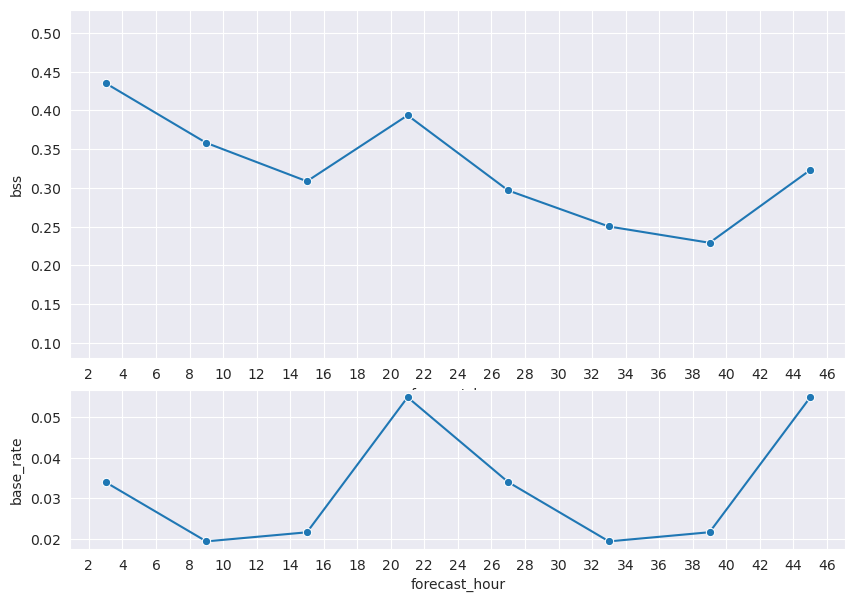

In [21]:
sns.set_style("darkgrid")
# Figure dimensions
# Don't overwrite fig variable from SPC stat_plot earlier.
# You may want to overlay NNPF on SPC stat_plot.
_ = plt.figure(figsize=(10, 7))

topax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
botax = plt.subplot2grid((3, 1), (2, 0), rowspan=1, sharex=topax)
botax.xaxis.set_major_locator(ticker.MultipleLocator(2))

ax = sns.lineplot(
    by_fhr.xs(f, level="class"),
    x="forecast_hour",
    y="bss",
    ax=topax,
    marker="o",
)
ax.set_ylim((0.08, 0.53))
ax = sns.lineplot(
    by_fhr.xs(f, level="class"),
    x="forecast_hour",
    y="base_rate",
    ax=botax,
    marker="o",
    legend=False,
)

0.435
0.358
0.308
0.393
0.296
0.249


2024-07-18 17:42:44,840 /glade/derecho/scratch/ahijevyc/tmp/nnpf.001+cg_20km_4hr.by_fhr.png


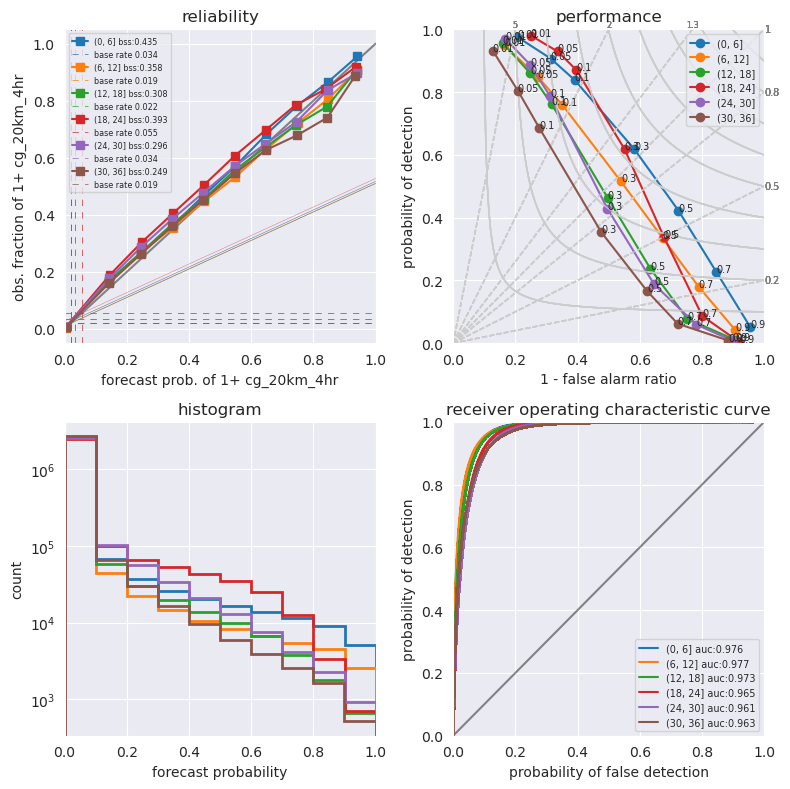

In [22]:
sns.set_style("darkgrid")
ncols, nrows = 2, 2
gfig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 4, nrows * 4))
for name, group in ensmean.groupby(
    by=[fhr_bin, lat_bin, lon_bin],
    observed=True,
):
    obs = group.xs("y_label", axis="columns", level=0)[f]
    fcst = group.xs("y_pred", axis="columns", level=0)[f]
    fcst.name = name[0]
    if name[0].left >= 36:
        continue
    gfig = stat_plots(
        obs,
        fcst,
        thresh=thresh,
        pthresh=pd.Series(
            np.round([0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9], 2), name="fcst prob\nthresh"
        ),
        o_thresh_roc=o_thresh,
        sep=0.15,
        fig=gfig,
    )
ofile = tmpdir / f"nnpf.{o_thresh:03d}+{f}.by_fhr.png"
plt.savefig(ofile, dpi=dpi)
logging.warning(ofile)

0.341


2024-07-18 17:43:10,699 /glade/derecho/scratch/ahijevyc/tmp/nnpf.001+cg_20km_4hr.all.initialization_time.valid_time.y.x.forecast_hour.lat.lon.png


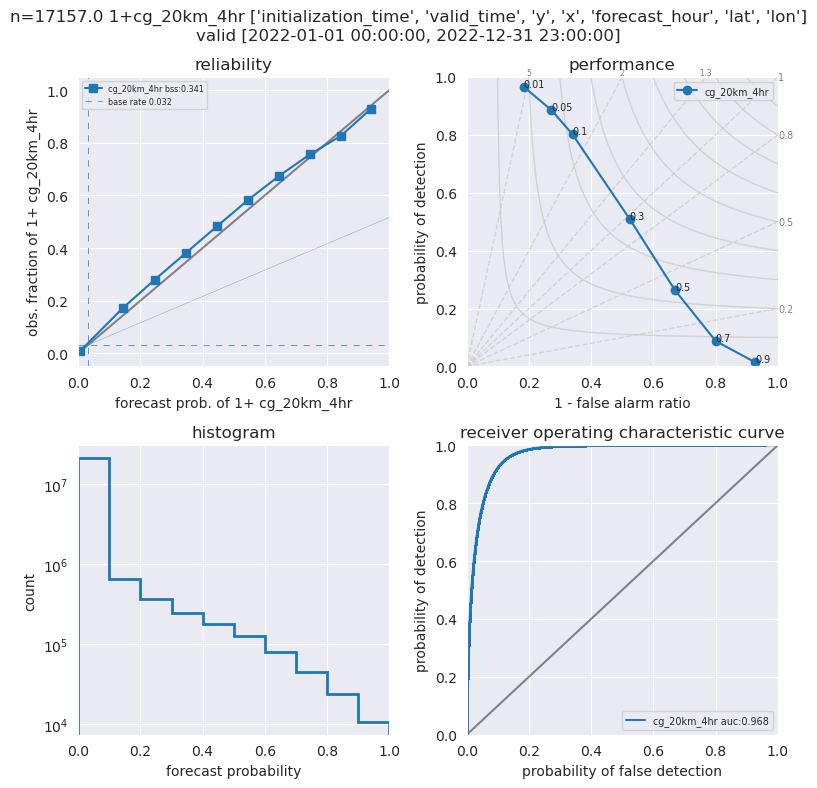

In [23]:
obs = ensmean.xs("y_label", axis="columns", level=0)
fcst = ensmean.xs("y_pred", axis="columns", level=0)

valid_range_str = (
    f'[{ensmean.index.get_level_values("valid_time").min()},'
    f' {ensmean.index.get_level_values("valid_time").max()}]'
)

_ = stat_plots(
    obs[f],
    fcst[f],
    thresh=thresh,
    pthresh=pd.Series(
        np.round([0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9], 2), name="fcst prob\nthresh"
    ),
    o_thresh_roc=o_thresh,
    sep=0.15,
    suptitle=f"n={len(ensmean)/G211.mask.values.sum()} {o_thresh}+{f} {levels}\nvalid {valid_range_str}",
)
ofile = tmpdir / f"nnpf.{o_thresh:03d}+{f}.all.{'.'.join(levels)}.png"
plt.savefig(ofile, dpi=dpi)
logging.warning(ofile)

## Restrict NNPF to valid times of SPC Thunderstorm Outlook

In [24]:
def pprod(record: str, fcst=fcst):
    """
    Return NNPF for the same valid range as
    an spc forecast record.
    Valid range may span multiple time windows, each
    with a separate NNPF.
    """
    s = record.name
    issue, valid_start, valid_end = get_issuance_time(s)
    NNPFtimes = pd.date_range(
        start=valid_start + pd.Timedelta(hours=twin / 2),
        end=valid_end - pd.Timedelta(hours=twin / 2),
        freq=f"{twin}h",
    )
    assert fcst.index.names[1] == "valid_time", "valid_time must be MultiIndex level 1"
    try:
        thisfcst = fcst.loc[(slice(None), NNPFtimes), :]
        # Probability of no occurences during multiple time windows
        # equals product of 1-p for each time window.
        prob_none = (1 - thisfcst).groupby(["y", "x"]).prod()
        # Probability of one or more occurrences is 1 minus that.
        p = 1 - prob_none
        return p
    except KeyError as err:
        logging.warning(f"{err} {s} {issue} [{valid_start},{valid_end}]")
    except:
        logging.error(f"pprod broke on {s} {issue} [{valid_start},{valid_end}]")
        sys.exit(1)


fhr_start = int(12 + twin / 2)
fhr_end = int(36 - twin / 2)
logging.warning(
    f"Limit forecast hour range [{fhr_start}, {fhr_end}], get ensemble mean"
)
# selected forecast hours only. drops level by default
fcst = fcst.xs(slice(fhr_start, fhr_end), level="forecast_hour")

pprod_par = tmpdir / f"ps.{args.teststart}-{args.testend}.fhr{fhr_start}-{fhr_end}.{o_thresh:03d}+{platform}.par"
if not clobber and os.path.exists(pprod_par):
    logging.warning(f"use old NNPF probability product output {pprod_par}")
    p = pd.read_parquet(pprod_par)
else:
    time0 = time.time()
    logging.warning(
        f"Save NNPF probability for each spc forecast (i.e. record) to {pprod_par}"
    )
    tqdm.pandas()
    p = spc_fcst.groupby("record").progress_apply(pprod, fcst=fcst)
    p.to_parquet(pprod_par)
    print(time.time() - time0)

logging.warning(
    "get (issuance time, valid hours) from NNPF forecasts matched to SPC records"
)
x = [get_issuance_time(s) for s in tqdm(p.index.get_level_values("record"))]
issue, valid_start, valid_end = map(np.array, zip(*x))

valid_start_hours = np.array([x.hour for x in valid_start])
valid_end_hours = np.array([x.hour for x in valid_end])

2024-07-18 17:43:11,574 Limit forecast hour range [14, 34], get ensemble mean
2024-07-18 17:43:12,141 use old NNPF probability product output /glade/derecho/scratch/ahijevyc/tmp/ps.2022-01-01 00:00:00-2023-01-01 00:00:00.fhr14-34.001+wbug.par
2024-07-18 17:43:13,471 get (issuance time, valid hours) from NNPF forecasts matched to SPC records
100%|██████████| 5569464/5569464 [01:17<00:00, 71943.74it/s]


In [25]:
p

cg_20km_4hr   ic_20km_4hr  \
record                                     y  x                                
enh00_20220101_012000_202201010557-shp.zip 12 48  3.073812e-04  6.038547e-04   
                                              49  6.515980e-04  1.066327e-03   
                                              69  0.000000e+00  0.000000e+00   
                                              70  0.000000e+00  0.000000e+00   
                                           13 47  0.000000e+00  0.000000e+00   
...                                                        ...           ...   
enh20_20221231_311600_202212311251-shp.zip 46 25  4.172325e-07  1.728535e-06   
                                              26  5.960464e-08  1.192093e-07   
                                              27  0.000000e+00  0.000000e+00   
                                              28  0.000000e+00  0.000000e+00   
                                              29  0.000000e+00  0.000000e+00   

                                                  cg.ic_20km_4hr  \
record                                     y  x                    
enh00_20220101_012000_202201010557-shp.zip 12 48    6.469488e-04   
                                              49    1.172900e-03   
                                              69    0.000000e+00   
                                              70    0.000000e+00   
                                           13 47    0.000000e+00   
...                                                          ...   
enh20_20221231_311600_202212311251-shp.zip 46 25    3.218651e-06   
                                              26    2.980232e-07   
                                              27    0.000000e+00   
                                              28    0.000000e+00   
                                              29    0.000000e+00   

                                                  flashes_20km_4hr  \
record                                     y  x                      
enh00_20220101_012000_202201010557-shp.zip 12 48      3.270507e-04   
                                              49      1.011789e-03   
                                              69      0.000000e+00   
                                              70      0.000000e+00   
                                           13 47      0.000000e+00   
...                                                            ...   
enh20_20221231_311600_202212311251-shp.zip 46 25      1.192093e-06   
                                              26      5.960464e-07   
                                              27      5.960464e-08   
                                              28      0.000000e+00   
                                              29      0.000000e+00   

                                                   cg_40km_4hr  ic_40km_4hr  \
record                                     y  x                               
enh00_20220101_012000_202201010557-shp.zip 12 48  1.110017e-03     0.003912   
                                              49  1.138270e-03     0.003260   
                                              69  0.000000e+00     0.000000   
                                              70  0.000000e+00     0.000000   
                                           13 47  6.556511e-07     0.000053   
...                                                        ...          ...   
enh20_20221231_311600_202212311251-shp.zip 46 25  2.324581e-06     0.000006   
                                              26  1.132488e-06     0.000001   
                                              27  2.384186e-07     0.000001   
                                              28  0.000000e+00     0.000000   
                                              29  0.000000e+00     0.000000   

                                                  cg.ic_40km_4hr  \
record                                     y  x                    
enh00_20220101_012000_202201010557-shp.zip 12 48  

2024-07-18 17:44:50,722 /glade/derecho/scratch/ahijevyc/tmp/leadtime.png


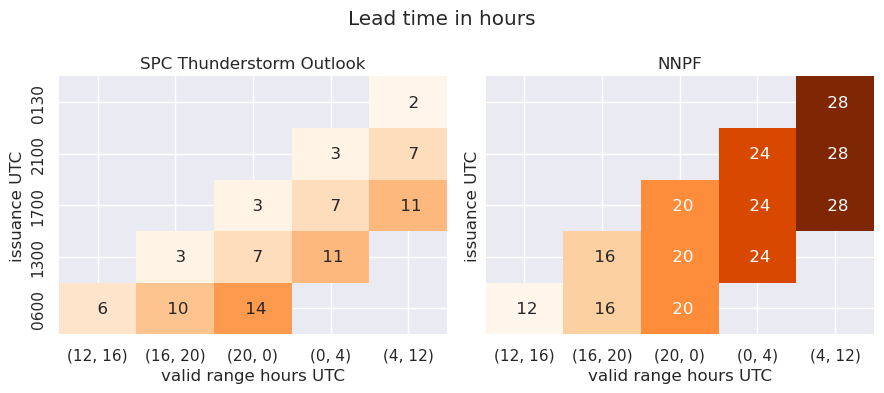

In [26]:
sns.set_theme()
flat_prods = [
    ("0600", 12, 16),
    ("0600", 16, 20), ("1300", 16, 20),
    ("0600", 20, 0), ("1300", 20, 0), ("1700", 20, 0),
    ("1300", 0, 4), ("1700", 0, 4), ("2100", 0, 4),
    ("1700", 4, 12), ("2100", 4, 12), ("0130", 4, 12),
]
leadtime_spc = {(i,v0,v1) : (v0 - (int(i[0:2])+float(i[2:])/60)) % 24 for (i, v0, v1) in flat_prods}
leadtime_spc = pd.Series(leadtime_spc)
leadtime_spc.index = leadtime_spc.index.to_flat_index()

leadtime_NNPF = {(i,v0,v1) : ((v0-12) % 24)+12 for (i, v0, v1) in flat_prods}
leadtime_NNPF = pd.Series(leadtime_NNPF)
leadtime_NNPF.index = leadtime_NNPF.index.to_flat_index()

# Don't use fig. save it from SPC stat_plot
_, ax = plt.subplots(ncols=2, figsize=(9,4), sharey=True)
g = plot_cnt(leadtime_spc, cmap="Oranges", ax=ax[0], vmax=28)
g.set_title("SPC Thunderstorm Outlook")
g = plot_cnt(leadtime_NNPF, cmap="Oranges", ax=ax[1], vmax=28)
g.set_title("NNPF")
plt.suptitle("Lead time in hours")
ofile = tmpdir / "leadtime.png"
plt.tight_layout()
plt.savefig(ofile, dpi=dpi)
logging.warning(ofile)

## Get obs at NNPF times
- verify, plot, overlay on SPC scores

n=357 1+cg_20km_4hr [('0600', 12, 16)] 0.232


2024-07-18 17:45:03,658 1 missing NNPF forecasts


n=339 1+cg_20km_4hr [('0600', 16, 20)] {'enh20_20220911_111600_202209110448-shp.zip'}
0.260


2024-07-18 17:45:04,777 old spc bss 0.23562107571944102 != new 0.23583465606289677


n=368 1+cg_20km_4hr [('1300', 16, 20)] 

2024-07-18 17:45:08,232 1 missing NNPF forecasts


{'enh20_20220911_111600_202209111246-shp.zip'}
0.261


2024-07-18 17:45:09,438 old spc bss 0.23760218541294187 != new 0.2378059054830105


n=342 1+cg_20km_4hr [('0600', 20, 0)] 0.316
n=348 1+cg_20km_4hr [('1300', 20, 0)] 0.312
n=377 1+cg_20km_4hr [('1700', 20, 0)] 0.315
n=338 1+cg_20km_4hr [('1300', 0, 4)] 0.217
n=375 1+cg_20km_4hr [('1700', 0, 4)] 0.214
n=357 1+cg_20km_4hr [('2100', 0, 4)] 0.214
n=349 1+cg_20km_4hr [('1700', 4, 12)] 

2024-07-18 17:45:41,601 2 missing NNPF forecasts


{'enh12_20220108_090400_202201081553-shp.zip', 'enh12_20220904_050400_202209041650-shp.zip'}
0.274


2024-07-18 17:45:42,787 old spc bss 0.24812476792340366 != new 0.24844188771911313


n=360 1+cg_20km_4hr [('2100', 4, 12)] 

2024-07-18 17:45:46,273 2 missing NNPF forecasts


{'enh12_20220904_050400_202209042015-shp.zip', 'enh12_20220108_090400_202201082012-shp.zip'}
0.268


2024-07-18 17:45:47,518 old spc bss 0.24978090683315568 != new 0.2500689142390009
2024-07-18 17:45:51,056 2 missing NNPF forecasts


n=348 1+cg_20km_4hr [('0130', 4, 12)] {'enh12_20220905_050400_202209050041-shp.zip', 'enh12_20220109_090400_202201090057-shp.zip'}
0.273


2024-07-18 17:45:52,241 old spc bss 0.2656823758075991 != new 0.2660843379605776
2024-07-18 17:45:53,375 made /glade/derecho/scratch/ahijevyc/tmp/floor_NNPF.001+cg_20km_4hr.png


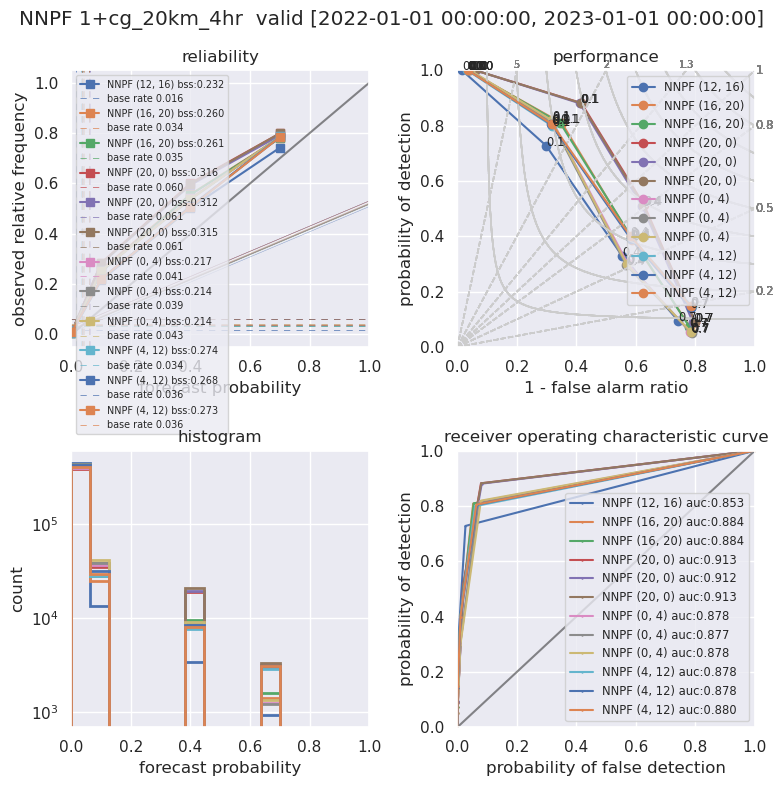

In [27]:
sns.set_theme()
obs = spc_fcst.reorder_levels(p.index.names).loc[p.index, [f, "DN"]]
fcst = p[f]

how="floor"
ztfs_func = partial(lightning.ztfs, how=how)
fcst = fcst.map(ztfs_func)  # round NNPF probs to limited SPC prob levels

keep_SPC_fig = len(prodidss) == 1
if not keep_SPC_fig:
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 4, nrows * 4))

nnpf_bss = {}
for prodids in prodidss:
    iprodid = (
        pd.Series(list(zip(issue, valid_start_hours, valid_end_hours)))
        .isin(prodids)
        .values
    )
    print(f"n={iprodid.sum()/G211.mask.values.sum():.0f} {o_thresh}+{f} {prodids}", end=" ")

    ihr = spc_fcst.prodid.isin(prodids)
    assert ihr.sum()

    # Sanity check
    # NNPF forecasts are missing when obsvar is missing in twin-h time window.
    # However there may be valid obsvar within longer valid time window of SPC forecast.
    # get_obs allows for missing obsvar. It just takes the mean of what is
    # available and then multiplies it by the total time window length.
    # e.g. you get a valid lightning count from
    # get_obs(pd.to_datetime("20210827T20"), pd.to_datetime("20210828T00"), obsvar, 2, rptdist)
    # but labels is missing for one of the 2-h components of that 4-hour SPC forecast valid time window.
    # labels.loc[("2021-08-27", "2021-08-27 21:00:00", 12, 48, slice(None))]
    missing_nnpf_forecasts = set(spc_fcst[ihr].groupby("record").first().index) - set(
        p[iprodid].groupby("record").first().index
    )
    if len(missing_nnpf_forecasts):
        logging.warning(f"{len(missing_nnpf_forecasts)} missing NNPF forecasts")
        print(missing_nnpf_forecasts)

    missing_SPC_forecasts = set(p[iprodid].groupby("record").first().index) - set(
        spc_fcst[ihr].groupby("record").first().index
    )
    if len(missing_SPC_forecasts):
        logging.warning(f"{len(missing_SPC_forecasts)} missing SPC forecasts")
        print(missing_SPC_forecasts)


    thisf = fcst[iprodid]
    thisf.name = "NNPF" + valid_hour_str(prodids)

    fig = stat_plots(
        obs.loc[iprodid, f],
        thisf,
        thresh=thresh,
        pthresh=pthreshSPC,
        o_thresh_roc=o_thresh,
        sep=0.15,
        n_bins=11,
        fig=fig,
    )
    if len(prodids) == 1:
        nnpf_bss[prodids[0]] = brier_skill_score(obs.loc[iprodid,f] >= o_thresh, thisf)        
    
        # make sure bss is same as before
        t = brier_skill_score(obs.loc[iprodid,f] >= o_thresh, obs.loc[iprodid, "DN"]/100.)
        if spc_bss[prodids[0]] != t:
            logging.warning(f"old spc bss {spc_bss[prodids[0]]} != new {t}")
axes[0,0].set_xlabel("forecast probability") # neat for paper
axes[0,0].set_ylabel("observed relative frequency") # neat for paper


title = f"NNPF {o_thresh}+{f}  valid [{valid_start.min()}, {valid_end.max()}]"
plt.suptitle(title, wrap=True)
plt.tight_layout()

ofile = tmpdir / f"{how}_NNPF.{o_thresh:03d}+{f}.png"
fig.savefig(ofile, dpi=dpi)
logging.warning(f"made {ofile}")

In [28]:
def stats(df, o_thresh=o_thresh):
    labels = df[f] >= o_thresh
    nnpf_pred = df[f+"NNPF"].map(ztfs_func)
    spc_pred = df["DN"]/100.

    bs_nnpf = np.mean((nnpf_pred - labels)**2)
    bs_spc  = np.mean((spc_pred  - labels)**2)
    bss_nnpf = brier_skill_score(labels, nnpf_pred)
    bss_spc  = brier_skill_score(labels,  spc_pred)

    df = pd.Series(
        {
            "bs_nnpf": bs_nnpf,
            "bs_spc": bs_spc,
            "bss_nnpf": bss_nnpf,
            "bss_spc": bss_spc,
            "base_rate": labels.mean(),
            "n": labels.count()/G211.mask.values.sum(),
        }
    )
    return df
import scipy.stats

In [29]:
xx = spc_fcst.join(p, rsuffix="NNPF").dropna() # TODO: remove dropna(). needed to deal with missing NNPF when matching SPC in 2022
        
def bootstrap(prodid):
    ofile = tmpdir / f"bootstrap.{args.teststart.strftime('%Y%m%d%H')}-{args.testend.strftime('%Y%m%d%H')}.{prodid[0]}.{prodid[1]}.{prodid[2]}.par"
    logging.warning(ofile)
    if os.path.exists(ofile):
        return pd.read_parquet(ofile)
    x = xx[xx["prodid"] == prodid]
    idates = pd.to_datetime(x.valid_start).dt.round(freq="1D")
    ss = []
    for i in tqdm(range(1000)):
        resampledDates = sklearn.utils.resample(idates.unique(), replace=True)
        vc = pd.Series(resampledDates).value_counts()
        xi = pd.concat([x.reindex(x[idates == v].index.repeat(c)) for v, c in vc.items()])
        ss.append(stats(xi))
    ss = pd.concat(ss, axis="columns").T
    ss.to_parquet(ofile)
    return ss

with Pool(processes=6) as pool:
    sss = pool.map(bootstrap, flat_prods)

2024-07-18 17:45:58,592 /glade/derecho/scratch/ahijevyc/tmp/bootstrap.2022010100-2023010100.0600.16.20.par
2024-07-18 17:45:58,592 /glade/derecho/scratch/ahijevyc/tmp/bootstrap.2022010100-2023010100.0600.12.16.par
2024-07-18 17:45:58,594 /glade/derecho/scratch/ahijevyc/tmp/bootstrap.2022010100-2023010100.0600.20.0.par
2024-07-18 17:45:58,594 /glade/derecho/scratch/ahijevyc/tmp/bootstrap.2022010100-2023010100.1300.20.0.par
2024-07-18 17:45:58,593 /glade/derecho/scratch/ahijevyc/tmp/bootstrap.2022010100-2023010100.1300.16.20.par
2024-07-18 17:45:58,594 /glade/derecho/scratch/ahijevyc/tmp/bootstrap.2022010100-2023010100.1700.20.0.par
100%|██████████| 1000/1000 [12:57<00:00,  1.29it/s]
2024-07-18 17:58:57,280 /glade/derecho/scratch/ahijevyc/tmp/bootstrap.2022010100-2023010100.2100.0.4.par
100%|██████████| 1000/1000 [14:10<00:00,  1.18it/s]
2024-07-18 18:00:09,539 /glade/derecho/scratch/ahijevyc/tmp/bootstrap.2022010100-2023010100.0130.4.12.par
100%|██████████| 1000/1000 [13:15<00:00,  1.26

In [30]:
ss = pd.concat(sss, keys=flat_prods, names=["issue","start_hr","end_hr"]).reset_index(level=["issue","start_hr","end_hr"])
ss['prodid'] = list(zip(ss.issue, ss.start_hr, ss.end_hr))
ss["d"] = ss["bss_nnpf"] - ss["bss_spc"]
ss

,issue,start_hr,end_hr,bs_nnpf,bs_spc,bss_nnpf,bss_spc,base_rate,n,prodid,d
0,0600,12,16,0.011299,0.011856,0.234728,0.197034,0.014989,358.0,"(0600, 12, 16)",0.037694
1,0600,12,16,0.010964,0.011561,0.226839,0.184709,0.014388,354.0,"(0600, 12, 16)",0.042130
2,0600,12,16,0.011832,0.012425,0.232818,0.194397,0.015669,358.0,"(0600, 12, 16)",0.038421
3,0600,12,16,0.011599,0.012165,0.232085,0.194632,0.015340,357.0,"(0600, 12, 16)",0.037453
4,0600,12,16,0.011641,0.012223,0.240800,0.202846,0.015576,361.0,"(0600, 12, 16)",0.037954
...,...,...,...,...,...,...,...,...,...,...,...
995,0130,4,12,0.028231,0.028920,0.288275,0.270889,0.041377,347.0,"(0130, 4, 12)",0.017386
996,0130,4,12,0.023940,0.024333,0.277133,0.265285,0.034295,351.0,"(0130, 4, 12)",0.011847
997,0130,4,12,0.024236,0.024463,0.276754,0.269995,0.034716,348.0,"(0130, 4, 12)",0.006759
998,0130,4,12,0.026482,0.027030,0.271953,0.256894,0.037804,349.0,"(0130, 4, 12)",0.015059


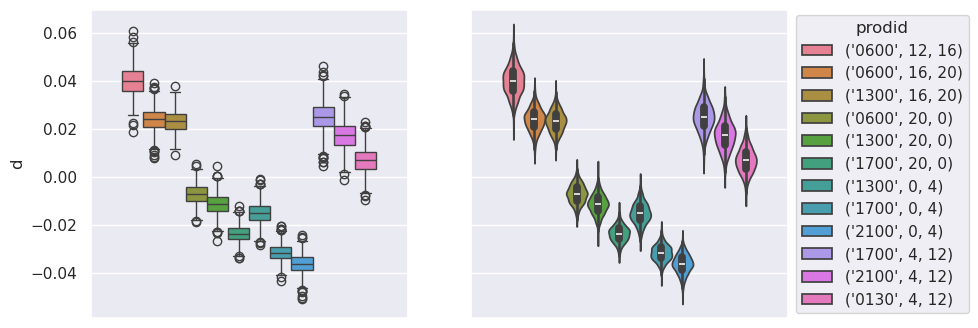

In [31]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(9,4))
sns.boxplot(data = ss, y="d", hue="prodid", ax=axes[0], legend=False)
sns.violinplot(data = ss, y="d", hue="prodid", ax=axes[1])
sns.move_legend(axes[1], "center left", bbox_to_anchor=(1,0.5))

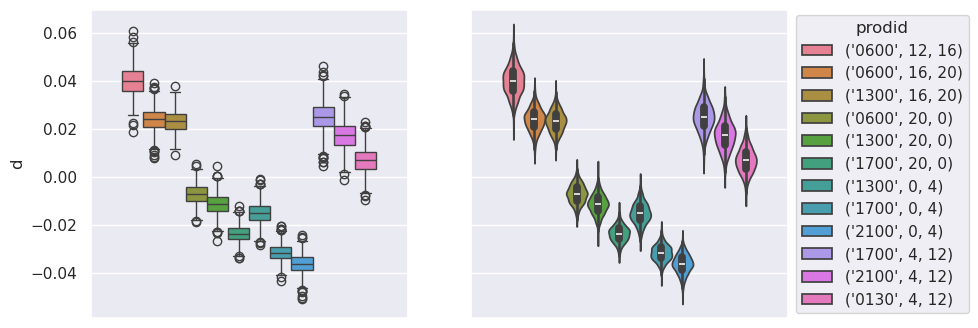

In [32]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(9,4))
sns.boxplot(data = ss, y="d", hue="prodid", ax=axes[0], legend=False)
sns.violinplot(data = ss, y="d", hue="prodid", ax=axes[1])
sns.move_legend(axes[1], "center left", bbox_to_anchor=(1,0.5))

In [33]:
def mean_confidence_interval(data, confidence_level=0.95):
    if False:
        a = 1.0 * np.array(data)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence_level) / 2., n-1)
        return m, h
    else:
        qlo = (1-confidence_level)/2 * 100
        qhi = 100-qlo
        lo, hi = np.percentile(data, [qlo, qhi])
        m = data.mean()
        return lo, data.mean(), hi

In [34]:
def bootstrap(data, **kwargs):
    res =  scipy.stats.bootstrap((data,), np.mean, **kwargs)
    ci_l, ci_u = res.confidence_interval
    return ci_l, np.mean(res.bootstrap_distribution), ci_u

## Compare BSS of SPC and NNPF

prodid
(0130, 4, 12)     Axes(0.125,0.11;0.775x0.77)
(0600, 12, 16)    Axes(0.125,0.11;0.775x0.77)
(0600, 16, 20)    Axes(0.125,0.11;0.775x0.77)
(0600, 20, 0)     Axes(0.125,0.11;0.775x0.77)
(1300, 0, 4)      Axes(0.125,0.11;0.775x0.77)
(1300, 16, 20)    Axes(0.125,0.11;0.775x0.77)
(1300, 20, 0)     Axes(0.125,0.11;0.775x0.77)
(1700, 0, 4)      Axes(0.125,0.11;0.775x0.77)
(1700, 4, 12)     Axes(0.125,0.11;0.775x0.77)
(1700, 20, 0)     Axes(0.125,0.11;0.775x0.77)
(2100, 0, 4)      Axes(0.125,0.11;0.775x0.77)
(2100, 4, 12)     Axes(0.125,0.11;0.775x0.77)
Name: d, dtype: object

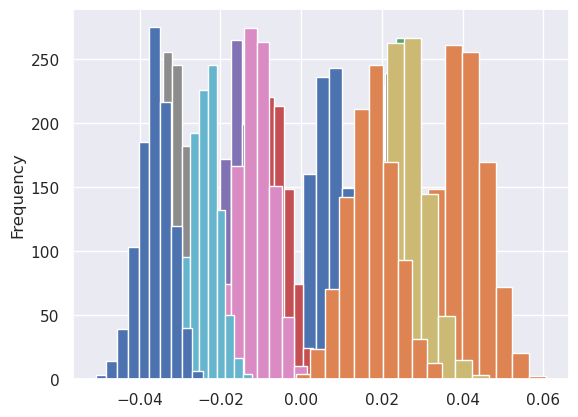

In [35]:
d = "d"
ss.groupby("prodid")[d].plot.hist()

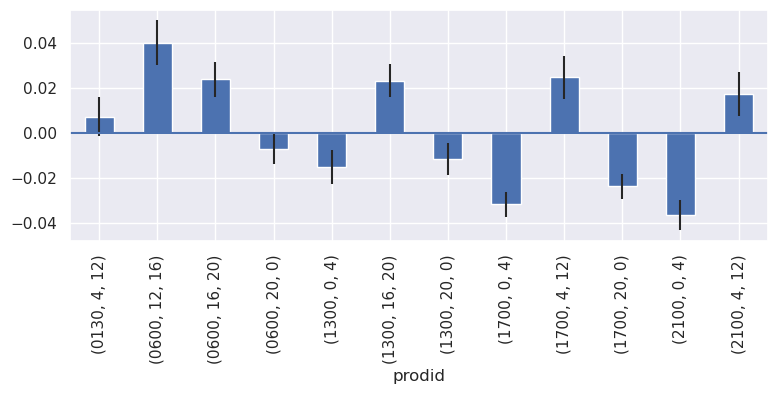

In [36]:
s = ss.groupby("prodid")[d].apply(mean_confidence_interval, confidence_level=.9)
s=pd.DataFrame(s.tolist(), index=s.index, columns=["l", d, "h"])

fig, ax=plt.subplots(figsize=(9,3))
s[d].plot.bar(ax=ax, yerr=(s[d] - s["l"], s["h"] - s[d])).axhline(y=0)


In [37]:
s = ss.groupby("prodid")[d].apply(mean_confidence_interval, confidence_level=0.9)

s = pd.DataFrame(
    s.tolist(),
    index=pd.MultiIndex.from_tuples(s.index, names=["issuance (HHMM UTC)", "start hour", "end hour"]),
    columns=["l", d, "h"],
)
s = (
    s.reindex(
        [
            ("0600", 12, 16),
            ("0600", 16, 20),
            ("0600", 20, 0),
            ("1300", 0, 4),
            ("1300", 16, 20),
            ("1300", 20, 0),
            ("1700", 0, 4),
            ("1700", 4, 12),
            ("1700", 20, 0),
            ("2100", 0, 4),
            ("2100", 4, 12),
            ("0130", 4, 12),
        ]
    )
    .unstack(level=["start hour", "end hour"])
    .reindex(["0130", "2100", "1700", "1300", "0600"])
)
s

l                                          \
start hour                 12        16        20        0         4    
end hour                   16        20        0         4         12   
issuance (HHMM UTC)                                                     
0130                      NaN       NaN       NaN       NaN -0.001412   
2100                      NaN       NaN       NaN -0.043244  0.007754   
1700                      NaN       NaN -0.029302 -0.037136  0.015282   
1300                      NaN  0.016013 -0.018573 -0.022486       NaN   
0600                 0.030275  0.016055 -0.013599       NaN       NaN   

                            d                                         \
start hour                 12       16        20        0         4    
end hour                   16       20        0         4         12   
issuance (HHMM UTC)                                                    
0130                      NaN      NaN       NaN       NaN  0.006950   
2100                      NaN      NaN       NaN -0.036266  0.017321   
1700                      NaN      NaN -0.023706 -0.031664  0.025076   
1300                      NaN  0.02328 -0.011357 -0.015071       NaN   
0600                 0.040098  0.02394 -0.007005       NaN       NaN   

                            h                                          
start hour                 12        16        20        0         4   
end hour                   16        20        0         4         12  
issuance (HHMM UTC)                                                    
0130                      NaN       NaN       NaN       NaN  0.016005  
2100                      NaN       NaN       NaN -0.029730  0.027149  
1700                      NaN       NaN -0.018255 -0.026039  0.034401  
1300                      NaN  0.030615 -0.004395 -0.007480       NaN  
0600                 0.050057  0.031526 -0.000591       NaN       NaN

In [38]:
sig = (s["l"] * s["h"] > 0).map(lambda x: "*" if x else "")
sig

start hour,12,16,20,0,4
end hour,16,20,0,4,12
issuance (HHMM UTC),,,,,
0130,,,,,
2100,,,,*,*
1700,,,*,*,*
1300,,*,*,*,
0600,*,*,*,,


2024-07-18 18:13:17,725 /glade/derecho/scratch/ahijevyc/tmp/DNNSPC.1+cg_20km_4hr.bss.2022.png


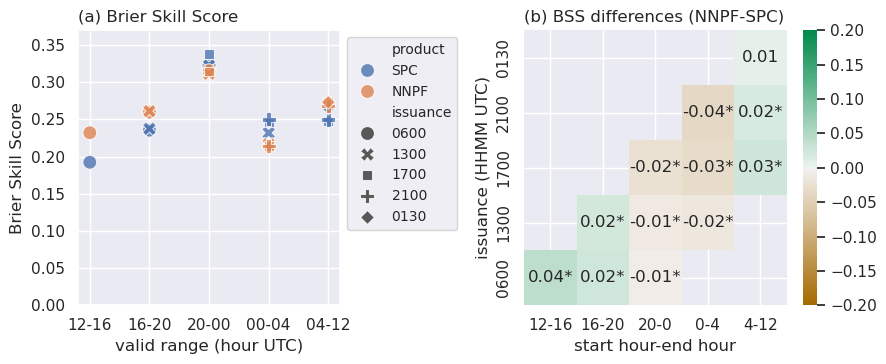

In [39]:
bss_df = pd.concat(
    [pd.Series(spc_bss, name="SPC"), pd.Series(nnpf_bss, name="NNPF")], axis="columns"
)
bss_df.index = pd.MultiIndex.from_tuples(
    [(i, f"{j:02d}-{k:02d}") for i, j, k in bss_df.index]
)
valid_hr_str = "valid range (hour UTC)"
bss_df.index.names = ["issuance", valid_hr_str]
bss_df.columns.name = "product"
bss_df = bss_df.reset_index().melt(
    id_vars=["issuance", valid_hr_str], value_name="Brier Skill Score"
)
fig, axes = plt.subplots(ncols=2, figsize=(9, 3.8), width_ratios=[0.8,1])

g = sns.scatterplot(
    bss_df,
    x=valid_hr_str,
    y="Brier Skill Score",
    hue="product",
    style="issuance",
    s=100,
    ax=axes[0],
    alpha=0.8,
)

sns.move_legend(g, loc="upper left", bbox_to_anchor=(1, 1, 0.1, 0.), fontsize="small")

g.set_title("(a) Brier Skill Score", loc="left")
g.set_ylim(0.0, 0.37)

g = sns.heatmap(
    s[d],
    ax=axes[1],
    annot=s[d].round(decimals=2).astype(str) + sig,
    fmt="",
    vmin=-0.2,
    vmax=0.2,
    cmap=sns.diverging_palette(45, 140, s=100, as_cmap=True),
)
g.set_title("(b) BSS differences (NNPF-SPC)", loc="left")

fig.tight_layout()
ofile = tmpdir / f"DNNSPC.{o_thresh}+{f}.bss.{args.teststart.strftime('%Y')}.png"
fig.savefig(ofile, dpi=dpi)
logging.warning(ofile)

In [40]:
bss_df

,issuance,valid range (hour UTC),product,Brier Skill Score
0,0600,12-16,SPC,0.192453
1,0600,16-20,SPC,0.235621
2,1300,16-20,SPC,0.237602
3,0600,20-00,SPC,0.322387
4,1300,20-00,SPC,0.322776
5,1700,20-00,SPC,0.338078
6,1300,00-04,SPC,0.231940
7,1700,00-04,SPC,0.245907
8,2100,00-04,SPC,0.250330
9,1700,04-12,SPC,0.248125
